---------STARTING TIME PROFILE TEST--------
(m,n) = (1,1)
FIRST TIMING
  0.000096 seconds (112 allocations: 4.859 KB)
NEXT TIMING----------------
  0.000004 seconds (10 allocations: 624 bytes)
  0.000009 seconds (14 allocations: 880 bytes)
size(newA) = (0,0)
  0.147170 seconds (8.53 k allocations: 415.531 KB)
-------------------RANDOMIZED TIME TESTS---------------------
---------STARTING TIME PROFILE TEST--------
(m,n) = (10,10)
FIRST TIMING
  0.000131 seconds (490 allocations: 14.016 KB)
NEXT TIMING----------------
  0.000008 seconds (17 allocations: 1.328 KB)
  0.000014 seconds (54 allocations: 4.703 KB)
size(newA) = (8,7)
  0.000464 seconds (1.34 k allocations: 45.016 KB)
AGAIN
---------STARTING TIME PROFILE TEST--------
(m,n) = (10,10)
FIRST TIMING
  0.000083 seconds (490 allocations: 14.297 KB)
NEXT TIMING----------------
  0.000005 seconds (10 allocations: 1008 bytes)
  0.000017 seconds (69 allocations: 5.781 KB)
size(newA) = (9,9)
  0.000456 seconds (1.42 k allocations: 47.578 K

before your program finished. To profile for longer runs, call Profile.init
with a larger buffer and/or larger delay.


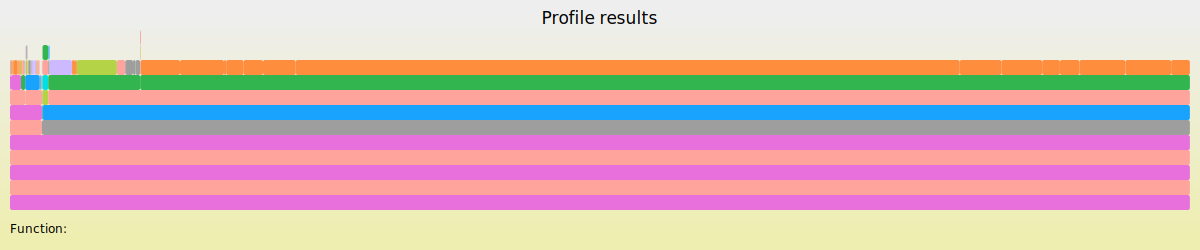

In [4]:
using MathProgBase
using GLPKMathProgInterface

#export presolver! (?)

# generates the unique key from row,col index for creating the dictionary
function rc(x::Int, y::Int, M::Int)
    return (x-1)*M + y
end

function roughly(x::Float64, y::Float64)
    if(abs(x-y) < 1e-3)
        return true
    else
        return false
    end
end

# A stack is needed to record information on redundancies removed
abstract PresolveStack

`A LinearDependency element represents -
x_index = val + \sum x[vec1[i]] * vec2[i]
if variable is fixed to a value then vec1,vec2 are null.
if variable is fixed to a linear dependency then
vec1 contains the indices of the elements in the constraint row that was removed.
vec2 contains the corresponding ratio of A matrix values.`
type LinearDependency <: PresolveStack
    index :: Int
    vec1 :: Vector{Int}
    vec2 :: Vector{Float64}
    value :: Float64

    function LinearDependency(ind::Int, val::Number)
        vec1 = Array{Int,1}()
        vec2 = Array{Float64,1}()
        new(ind,vec1,vec2,val)
    end
end

# function that will add the LinearDependency element to the stack.
function add_to_stack!(l::LinearDependency, independentvar::BitArray{1}, pstack::Array{PresolveStack,1})
    if (length(l.vec1) != length(l.vec2))
        error("vector1 size not equal to vector 2 size for LD element")
    end
    independentvar[l.index] = false # the variable at this index is not independent anymore
    push!(pstack,l)
end

# function that will post solve one LinearDependency element.
function post_solve!(post_solvedX::Array{Float64,1}, l::LinearDependency)
    post_solvedX[l.index] = l.value

    for i in 1:length(l.vec1)
        post_solvedX[l.index] += l.vec2[i]*post_solvedX[l.vec1[i]]
    end
end

# the x that is fed in has to be the solution obtained from the Solver.
function return_postsolved(x::Array{Float64,1}, independentvar::BitArray{1}, pstack :: Array{PresolveStack,1})
    postsolvedX = zeros(length(independentvar))
    newcols = find(independentvar)

    for i in 1:length(newcols)
        postsolvedX[newcols[i]] = x[i]
    end

    for i in reverse(collect(1:length(pstack)))
        post_solve!(postsolvedX,pstack[i])
    end
    return postsolvedX
end

# Type that will hold the details about the presolve problem we are constructing. The dictionary is made here.
type Presolve_Problem
    currentc :: Array{Float64,1}
    dictA :: Dict{Float64,Float64}
    currentb :: Array{Float64,1}
    currentlb :: Array{Float64,1}
    currentub :: Array{Float64,1}
    #rowindices :: Array{Array{Int64,1},1}
    #colindices :: Array{Array{Int64,1},1}
    independentvar :: BitArray{1}
    activeconstr :: BitArray{1}
    pstack :: Array{PresolveStack,1}
    originalm :: Int64
    originaln :: Int64
    bitmat :: BitArray{2}
    rowcounter :: Array{Float64,1}
    colcounter :: Array{Float64,1}

    #   Constructor that creates a Presolve_Problem
    function Presolve_Problem(c::Array{Float64,1},A::SparseMatrixCSC{Float64,Int64},b::Array{Float64,1},lb::Array{Float64,1},ub::Array{Float64,1})
    #   println("-----------INSIDE PRESOLVE CONSTRUCTOR------------")
        originalm,originaln = size(A)

    #   checks to ensure input problem is valid.
        originalm != length(b) && error("Wrong size of b wrt A")
        originaln != length(lb) && error("Wrong size of lb wrt A")
        originaln != length(ub) && error("Wrong size of ub wrt A")
        originaln != length(c) && error("Wrong size of c wrt A")

    #   SETUP
        independentvar = trues(originaln)
        activeconstr = trues(originalm)
        pstack = Array{PresolveStack,1}()
        dictA = Dict{Float64,Float64}()
        rowcounter = zeros(originalm)
        colcounter = zeros(originaln)
        #rowindices = Array{Int,1}[Int[] for i=1:originalm]
        #colindices = Array{Int,1}[Int[] for i=1:originaln]
        bitmat = falses(originalm,originaln)

    #   Iterating through the non-zeros of sparse matrix A to construct the dictionary
        Arows = rowvals(A)
        Avals = nonzeros(A)
        for j = 1:originaln
            for i in nzrange(A,j)
                r = Arows[i]
                v = Avals[i]
                rcval = rc(r,j,originaln)
                dictA[rcval] = v
                #push!(rowindices[r],j)
                #push!(colindices[j],r)
                rowcounter[r] += 1
                colcounter[j] += 1
                bitmat[r,j] = true
            end
        end

        #new(c,dictA,b,lb,ub,rowindices,colindices,independentvar,activeconstr,pstack,originalm,originaln,bitmat)
        new(c,dictA,b,lb,ub,independentvar,activeconstr,pstack,originalm,originaln,bitmat,rowcounter,colcounter)
    end
end

function presolver!(c::Array{Float64,1}, A::SparseMatrixCSC{Float64,Int64}, b::Array{Float64,1}, lb::Array{Float64,1}, ub::Array{Float64,1})
    #println("Making presolve")
    p = Presolve_Problem(c::Array{Float64,1}, A::SparseMatrixCSC{Float64,Int64}, b::Array{Float64,1}, lb::Array{Float64,1}, ub::Array{Float64,1})

    #counter = 0
    #while(counter >= 0)
        # println("Empty row call")
        # detects empty rows, throws infeasibilty error or marks it for removal
        er = empty_rows!(p::Presolve_Problem)
        #@show er
        # println("Empty col call")
        # detects emtpy col, throws unbounded error or marks it for removal
        ec = empty_cols!(p::Presolve_Problem)
        #@show ec
        # println("fixed variables call")
        #detects fixed variables, throws infeasiblity error or marks it for removal
        fv = fixed_variables!(p::Presolve_Problem)
        #@show fv
        #println("remove fv")
        # removes all fixed variable from the current copy of data.
        #remfv = remove_fixed!(p::Presolve_Problem)
        #@show remfv
        #println("singleton row call")
        # detects singleton rows
        @time sr = singleton_rows!(p::Presolve_Problem)
        #sr = false
        #@show sr
        #println("to next iteration")
    #    if(!(er||ec||fv||sr))
    #        break
    #    end
    #    counter+=1
    #end

    #println("trying make new")
    #@time newc,newA,newb,newlb,newub = make_new(p::Presolve_Problem)
            @time c,A,b,lb,ub = make_new(p::Presolve_Problem)
    return c,A,b,lb,ub,p.independentvar,p.pstack
    #return newc,newA,newb,newlb,newub,p.independentvar,p.pstack
end

    # detecting and removing empty rows.
function empty_rows!(p::Presolve_Problem)
    empty_row = false
    for i in 1:p.originalm
        if(p.activeconstr[i] == false)
            continue
        end
        #if(length(p.rowindices[i])==0)
        if(p.rowcounter[i] == 0)
            #println("Detected Empty Row at $i")
            !(roughly(p.currentb[i],0.0)) && error("Empty Row Infeasibility at row $i and b[i] is - $(p.currentb[i])")
            p.activeconstr[i] = false
            empty_row = true
		end
    end
    #println("Exiting Empty Row and returning $empty_row")
    return empty_row
end

    # detecting and removing empty cols.
function empty_cols!(p::Presolve_Problem)
    empty_col = false
    for j in 1:p.originaln
        if(p.independentvar[j] == false)
            continue
        end
        #if(length(p.colindices[j])==0)
        if(p.colcounter[j] == 0)
                #println("Detected Empty col / Unrestricted variable at $j")
            (p.currentc[j] != 0)*(p.currentlb[j] == -Inf64) && error("Problem is unbounded.")
            p.independentvar[j] = false
            empty_col = true
        end
    end
    #println("Exiting Empty col and returning $empty_col")
    return empty_col
end

    # detecting an infeasible or fixed variable
function fixed_variables!(p::Presolve_Problem)
    detect_fixed = false
    for j in 1:p.originaln
        if(p.independentvar[j] == false)
            continue
        end
        (p.currentlb[j] > p.currentub[j]) && error("Infeasible bounds at $j")
        if(p.currentlb[j] == p.currentub[j])
            add_to_stack!(LinearDependency(j,p.currentlb[j]),p.independentvar,p.pstack)
            detect_fixed = true
        end
    end
    #println("Exiting fixed variable and returning $detect_fixed")
    return detect_fixed
end

    # Removing Fixed Variables
function remove_fixed!(p::Presolve_Problem)
    variable_remove = false
    for j in length(p.independentvar)
        if(p.independentvar[j])
            if((p.currentlb[j] != -Inf64) && p.currentlb[j] == p.currentub[j])
                #println("Found a fixed variable at $j")
                tmp = p.currentlb[j]
                add_to_stack!(LinearDependency(j,tmp),p.independentvar,p.pstack)
                #TODO : substitution into objective function

                #substitution into matrix
                for k in 1:N
                    for i in 1:length(p.rowindices[k])
                        if(p.rowindices[k][i]==j)
                            if length(p.rowindices[k])==1
                                #only x_j variable in this row
                                if((tmp - p.currentb[k]/p.dictA[rc(k,j)]) != 0)
                                    error("Infeasible Problem")
                                end
                                p.currentb[k] -= p.dictA[rc(k,j)]*tmp
                                splice!(p.rowindices[k],i)
                                delete!(p.dictA,rc(k,j));
                                break
                            end
                        end
                        if p.rowindices[k][i] > j
                                break
                        end
                end
            end
            variable_remove = true
            p.colindices[j]=Vector{Int64}[]
            end
        end
    end
    #println("Exiting variable remove and returning $variable_remove")
    return variable_remove
end

    # SINGLETON ROW
function singleton_rows!(p::Presolve_Problem)
    singleton_row = false
    #srows = falses(p.originalm)
    svariable = zeros(p.originaln)

    for i in 1:p.originalm
        if(p.activeconstr[i] == false)
            continue
        end
        #if(length(p.rowindices[i])==1)
        if(p.rowcounter[i] == 1)
            #println("found a row singleton at row $i")
            #j = p.rowindices[i][1]
            j = find(p.bitmat[i,:])[1]
            if(p.independentvar[j] == false)
                continue
            end
            aij = p.dictA[rc(i,j,p.originaln)]
            aij == 0 && error("Unexpected Zero")
            xj = p.currentb[i]/aij
            add_to_stack!(LinearDependency(j,xj),p.independentvar,p.pstack)
            p.activeconstr[i] = false
            singleton_row = true
                    #    srows[i] = true
            svariable[j] = xj
         end
    end

    k = find(p.bitmat)

    for ind in 1:length(k)
        i = k[ind] % p.originalm == 0 ? p.originalm : k[ind]%p.originalm
        j = Int((k[ind] - i)/p.originalm + 1)
        key = rc(i,j,p.originaln)
        if(svariable[j]!=0)
            p.currentb[i] -= svariable[j]*p.dictA[key]
            delete!(p.dictA,key)
            p.bitmat[i,j] = false
            p.rowcounter[i] -= 1
            #splice!(p.rowindices[i],j)
        end
    end
    return singleton_row
end

    # to make c,A,sense,b,l,u
function make_new(p::Presolve_Problem)
    newc = Array{Float64,1}()
    for j in 1:p.originaln
        if(p.independentvar[j])
            push!(newc,p.currentc[j])
        end
    end

    newb = Array{Float64,1}()
    for j in 1:p.originalm
        if(p.activeconstr[j])
            push!(newb,p.currentb[j])
        end
    end

    newrows = find(p.activeconstr)
    newcols = find(p.independentvar)

    # constructing a sparse matrix
    #@show len = length(p.dictA)
    I = Array{Int64,1}()
    J = Array{Int64,1}()
    Val = []

    for rowiter in 1:length(newrows)
        for coliter in 1:length(newcols)
            if(haskey(p.dictA,rc(newrows[rowiter],newcols[coliter],p.originaln)))
                push!(I,rowiter)
                push!(J,coliter)
                push!(Val,p.dictA[rc(newrows[rowiter],newcols[coliter],p.originaln)])
            end
        end
    end
    newA = sparse(I,J,Val,length(newrows),length(newcols))

    newlb = zeros(length(newcols))
    for coliter in 1:length(newcols)
        newlb[coliter] = p.currentlb[newcols[coliter]]
    end

    newub = zeros(length(newcols))
    for coliter in 1:length(newcols)
        newub[coliter] = p.currentub[newcols[coliter]]
    end
    return newc,newA,newb,newlb,newub
end


function make_lp(m::Int, n::Int, s::Float64)
    #m = rand((1:100))
    #n = rand((1:100))
    #m = 1000
    #n = 1000
    #enron data set contained 36,692 nodes and 183,831 nodes at sparsity of 0.00013
    #m = 36692
    #n = 36692
    c = ones(n)
    x = rand((1:1000),n)
    A = sprand(m,n,s)
    b = A*x
    lb = float(copy(x))
    ub = 1000000*ones(n)
    return m,n,c,A,b,lb,ub,x
end

# this is only needed because of the way I have generated sample LP instances. Not significant time cost anyway
function trim(x::Array{Float64,1}, y::Array{Float64,1})
    for i in 1:length(x)
        if(x[i] < y[i])
            x[i] = y[i]
        end
    end
    return x
end

#simplest test, fetch one nice instance and compare.
function correctness_test(in1::Int, in2::Int, in3::Float64)
    i=1
    j=1
    tol = 1e-3

    while(i<= 100)
        println("---------STARTING ITERATION $i---------")
        m,n,c,A,b,lb,ub,x = make_lp(in1,in2,in3)
        tolerance = tol * ones(n)
        #@show x
        #@show c
        #@show A
        #@show b
        #@show lb
        #@show ub

        newc,newA,newb,newlb,newub,independentvar,pstack = presolver!(c,A,b,lb,ub)

        #@show size(newA), typeof(newA)
        #@show size(newc)
        #@show size(newb)
        #@show size(x), typeof(x)

        ans = Array{Float64,1}()
        if(length(find(independentvar))!=0)
            presol = linprog(newc, newA, '=', newb, GLPKSolverLP(presolve=false))
            #presol = linprog(newc, newA, '=', newb,newlb,newub)
            presol.status != :Optimal && error("Input feasible problem with an optimal solution but after presolving solver status is not optimal")
            ans = presol.sol
        end
        finalsol = return_postsolved(ans,independentvar,pstack)
        #@show finalsol, typeof(finalsol)
        finalsol = trim(finalsol,lb)

        if( ((x - finalsol) .< tolerance) == trues(n) )
            println("PASS!")
            j+=1
        else
            @show x - finalsol
            @show A*x
            @show A*finalsol
            error("DIDNT PASS!!!")
        end
        i+=1
    end
    if(i == j)
        println("------Presolve works subject to randomized testing-----")
    end
end

function time_test(in1::Int, in2::Int, in3::Float64)
    tol = 1e-3
    println("---------STARTING TIME PROFILE TEST--------")
    m,n,c,A,b,lb,ub,x = make_lp(in1,in2,in3)
    @show m,n

    tolerance = tol * ones(n)
    println("FIRST TIMING")
    @time begin
        answer = linprog(c,A,'=',b,lb,ub,GLPKSolverLP(presolve=true))
        answer.status != :Optimal && error("Input feasible problem with an optimal solution but solver status is not optimal")
    end
println("NEXT TIMING----------------")

@time begin
        newc,newA,newb,newlb,newub,independentvar,pstack = presolver!(c,A,b,lb,ub)
        @show size(newA)
        #(newA == A) && error("No Presolving Done")
        ans = Array{Float64,1}()
            if(length(find(independentvar))!=0)
                    presol = linprog(newc, newA, '=', newb,newlb,newub, GLPKSolverLP(presolve=true))
            #presol = linprog(newc, newA, '=', newb,newlb,newub)
            presol.status != :Optimal && error("Input feasible problem with an optimal solution but after presolving solver status is not optimal")
            ans = presol.sol
            end
        finalsol = return_postsolved(ans,independentvar,pstack)
        finalsol = trim(finalsol,lb)
    end
    #@show answer.sol
    #@show finalsol
end

function do_tests(correctness::Bool, time::Bool)
    if(correctness)
        #correctness_tests
        correctness_test(1000,1000,0.001)
    end

    if(time)
        # Time-Profile tests
        time_test(10,10,0.3)
        println("AGAIN")        
        time_test(10,10,0.3)
        println("AGAIN")
        time_test(100,100,0.01)
        println("AGAIN")
        time_test(1000,1000,0.001)
        println("AGAIN")
        time_test(10000,10000,0.0001)
        println("AGAIN")
        time_test(100000,100000,0.00001)
    end
end

#println("-------------------RANDOMIZED CORRECTNESS TESTS-----------------")
#do_tests(true,false)

time_test(1,1,0.3)
Profile.clear()

println("-------------------RANDOMIZED TIME TESTS---------------------")
@profile do_tests(false,true)

#Profile.print(format=:flat)
using ProfileView
ProfileView.view()
#ProfileView.svgwrite("profile_results.svg")
